In [1]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import importlib
from IPython.display import HTML

%matplotlib ipympl
plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=200, formatter={'float': '{:.3e}'.format})
# np.set_printoptions(linewidth=200, formatter={'float': '{:.1f}'.format})

In [2]:
# Fundamental constants
h    = 6.62607015e-34
GHz  = 1e9
e0   = 1.602176634e-19
Φ_0 = h/(2*e0)

# KIT's qubit

This notebook studies the qubit proposed by KIT. It's lumped element model is:
<img src='../Other/Single qubit 4 nodes CC coupled to ground.jpg' width='500'>


# Circuit definitions
## Qubit

In [33]:
# Circuit parameters
Csh = 15
C   = 15
Cg  = 10
CJ  = 3
Lq  = 25
Lr  = 10
# Δ   = 0.1
Δ   = 2
EJ  = 10.0
l = Lq*(Lq+4*Lr) - 4*Δ**2

In [34]:
Cf = C/2 + Csh + CJ
Lf = l/(Lq+4*Lr)
C_f = Cf * 1e-15
L_f = Lf * 1e-9
Z_f = np.sqrt(L_f/C_f)

L_r = l/Lq * 1e-9
C_r = C/2 * 1e-15
Z_r = np.sqrt(L_r/C_r)

In [35]:
qubit = sq_ext.sq_qubit(C = C, CJ = CJ, Csh= Csh , Lq = Lq, Lr = Lr, Δ = Δ, EJ = EJ)
loop = qubit.loops[0]
qubit.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [36]:
sq_ext.print_flux_transformation(qubit)

Φ_1 = [ 0.00  0.00  1.00]
Φ_2 = [ 1.00  0.70  0.54]
Φ_3 = [-0.24  1.00  0.17]


# Equivalent circuits

### Resonator

In [37]:
resonator_elements = {
    # (0, 1): [sq.Capacitor(C/2, 'fF'), sq.Inductor (l/Lq, 'nH')],
    (0, 1): [sq.Capacitor(C/2 * 1e-15, 'F'), sq.Inductor (l/Lq * 1e-9, 'H')],
}
resonator = sq.Circuit(resonator_elements )
resonator.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Fluxonium

In [38]:
Cf = C/2 + Csh + CJ
Lf = l/(Lq+4*Lr)

C_f = Cf * 1e-15
L_f = Lf * 1e-9
loop_fluxonium = sq.Loop(0.5)
fluxonium_elements = {
    (0, 1): [sq.Capacitor(C/2 + Csh + CJ, 'fF'), 
             sq.Inductor(Lf, 'nH', loops=[loop_fluxonium]),
             sq.Junction(EJ, 'GHz', loops=[loop_fluxonium])],
}
fluxonium = sq.Circuit(fluxonium_elements)
fluxonium.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Spectrum

## Resonator spectrum

In [39]:
L_r = l/Lq * 1e-9
C_r = C/2 * 1e-15
w_r = 1/np.sqrt(L_r*C_r) / 2 / np.pi / GHz
E_harm = w_r * np.arange(0,8)
E_harm

array([0.000e+00, 7.244e+00, 1.449e+01, 2.173e+01, 2.898e+01, 3.622e+01, 4.346e+01, 5.071e+01])

In [40]:
resonator.set_trunc_nums([10])
_ = resonator.diag(6)
resonator._efreqs

array([-1.231e-06, 4.552e+10, 9.103e+10, 1.365e+11, 1.821e+11, 2.276e+11])

## Spectrum vs external flux

In [41]:
qubit.set_trunc_nums([5, 15])
fluxonium.set_trunc_nums([15])

# spectrum of the qubit
# phi = np.linspace(0,1,200)
#
phi = np.concatenate((np.linspace(0,0.36,50),np.linspace(0.36,0.38,50), np.linspace(0.38,0.46,10), np.linspace(0.46,0.47,50), np.linspace(0.5,0.6,20), np.linspace(0.6,1,20)))
n_eig=10
E_circuit = np.zeros((n_eig, len(phi)))
E_fluxonium = np.zeros((n_eig//2, len(phi)))

eig_colors = plt.get_cmap('viridis_r')(np.linspace(0, 255, n_eig).astype('int'))
for i in range(len(phi)):
    # set the external flux for the loop
    loop_fluxonium.set_flux(phi[i])
    loop.set_flux(phi[i])
    # diagonalize the qubit
    E_circuit[:, i] = qubit.diag(n_eig)[0]
    E_fluxonium[:, i] = fluxonium.diag(n_eig//2)[0]

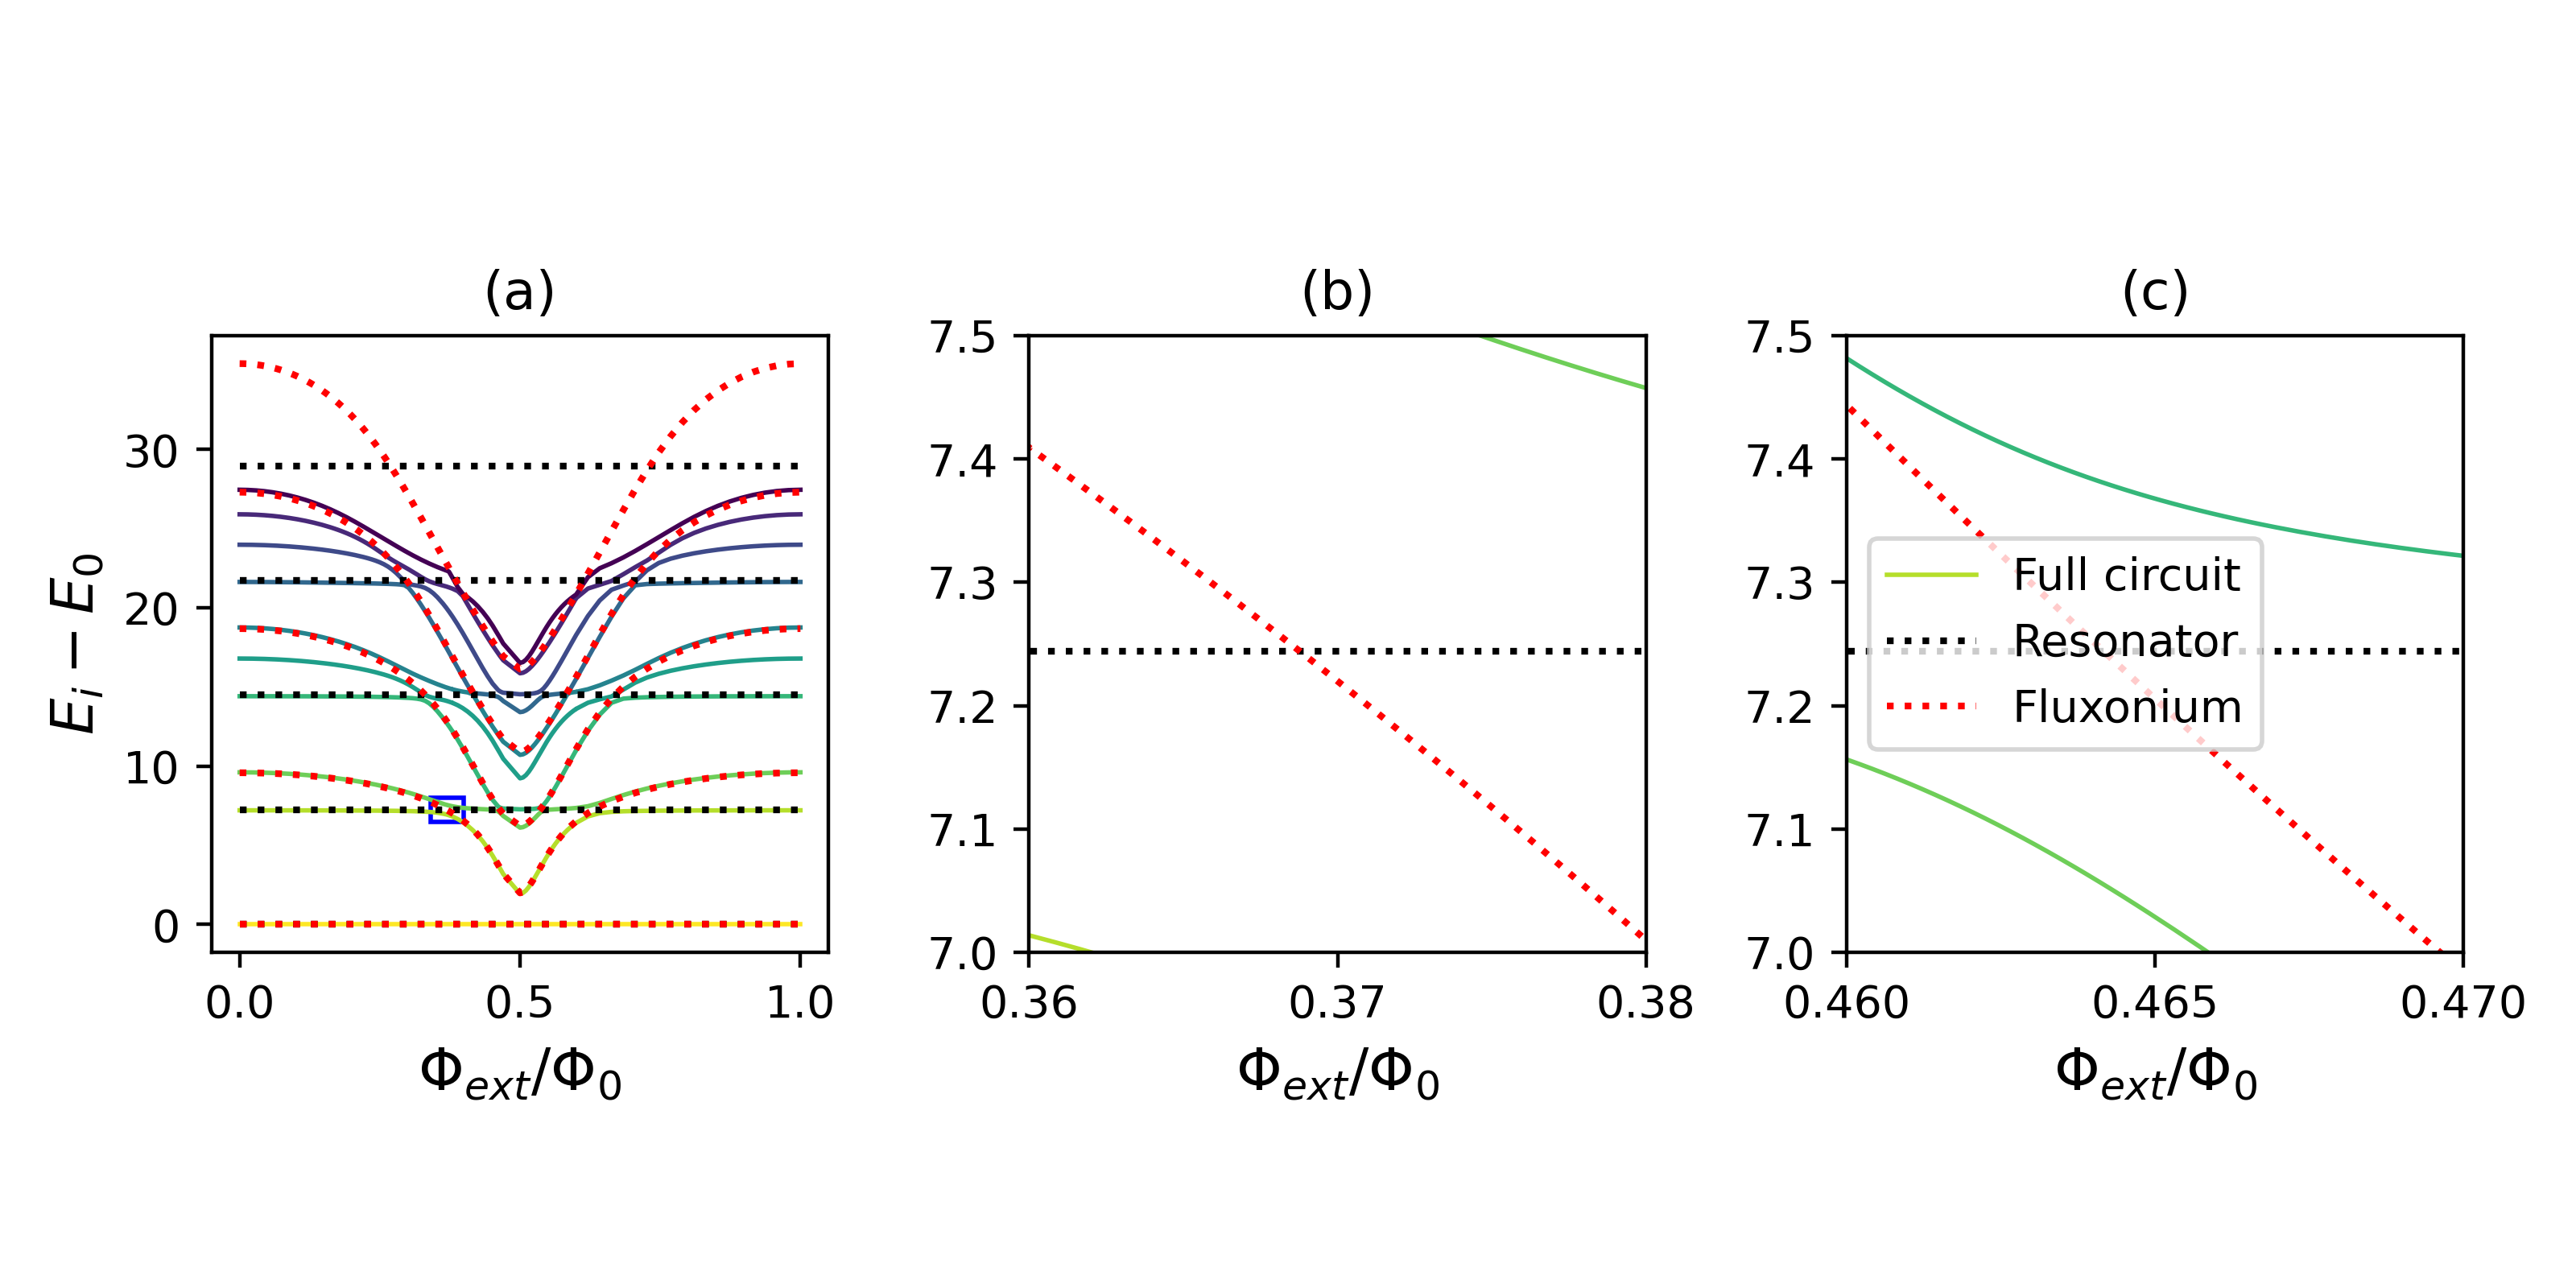

In [42]:
import matplotlib.patches as patches

# Create a rectangle with no fill

fig, axs = plt.subplots(dpi=400, ncols=3, figsize = [8,4])

for ax in axs:
    for i in range(n_eig):
        if i ==1:
            ax.plot(phi, E_circuit[i,:]- E_circuit[0,:], color=eig_colors[i], linewidth=1, label='Full circuit')
        else:
            ax.plot(phi, E_circuit[i,:]- E_circuit[0,:], color=eig_colors[i], linewidth=1)
    for i in range(n_eig//2):
        if i ==0:
            ax.plot([phi[0],phi[-1]], [E_harm[i],E_harm[i]], ':k' , label='Resonator')
            ax.plot(phi, E_fluxonium[i,:]- E_fluxonium[0,:], color='r', linestyle = ':', label='Fluxonium')
        else:
            ax.plot([phi[0],phi[-1]], [E_harm[i],E_harm[i]], ':k' )
            ax.plot(phi, E_fluxonium[i,:]- E_fluxonium[0,:], color='r', linestyle = ':')

    ax.set_box_aspect(1)
    ax.set_xlabel(r"$\Phi_{ext}/\Phi_0$", fontsize=13)
    if ax == axs[0]:
        rect = patches.Rectangle((0.34, 6.5), 0.06, 1.5, linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
        ax.set_title('(a)')
        ax.set_ylabel(r"$E_i-E_0$", fontsize=13)
    elif ax == axs[1]:
        ax.set_title('(b)')
        ax.set_xlim(0.36,0.38)
        ax.set_ylim(7,7.5)

    else :
        ax.set_title('(c)')
        ax.set_xlim(0.46,0.47)
        ax.set_ylim(7,7.5)
        ax.set_xticks([0.46, 0.465, 0.47])
        ax.legend()
fig.tight_layout()
fig.show()
figs.export('Spectrum.pdf')

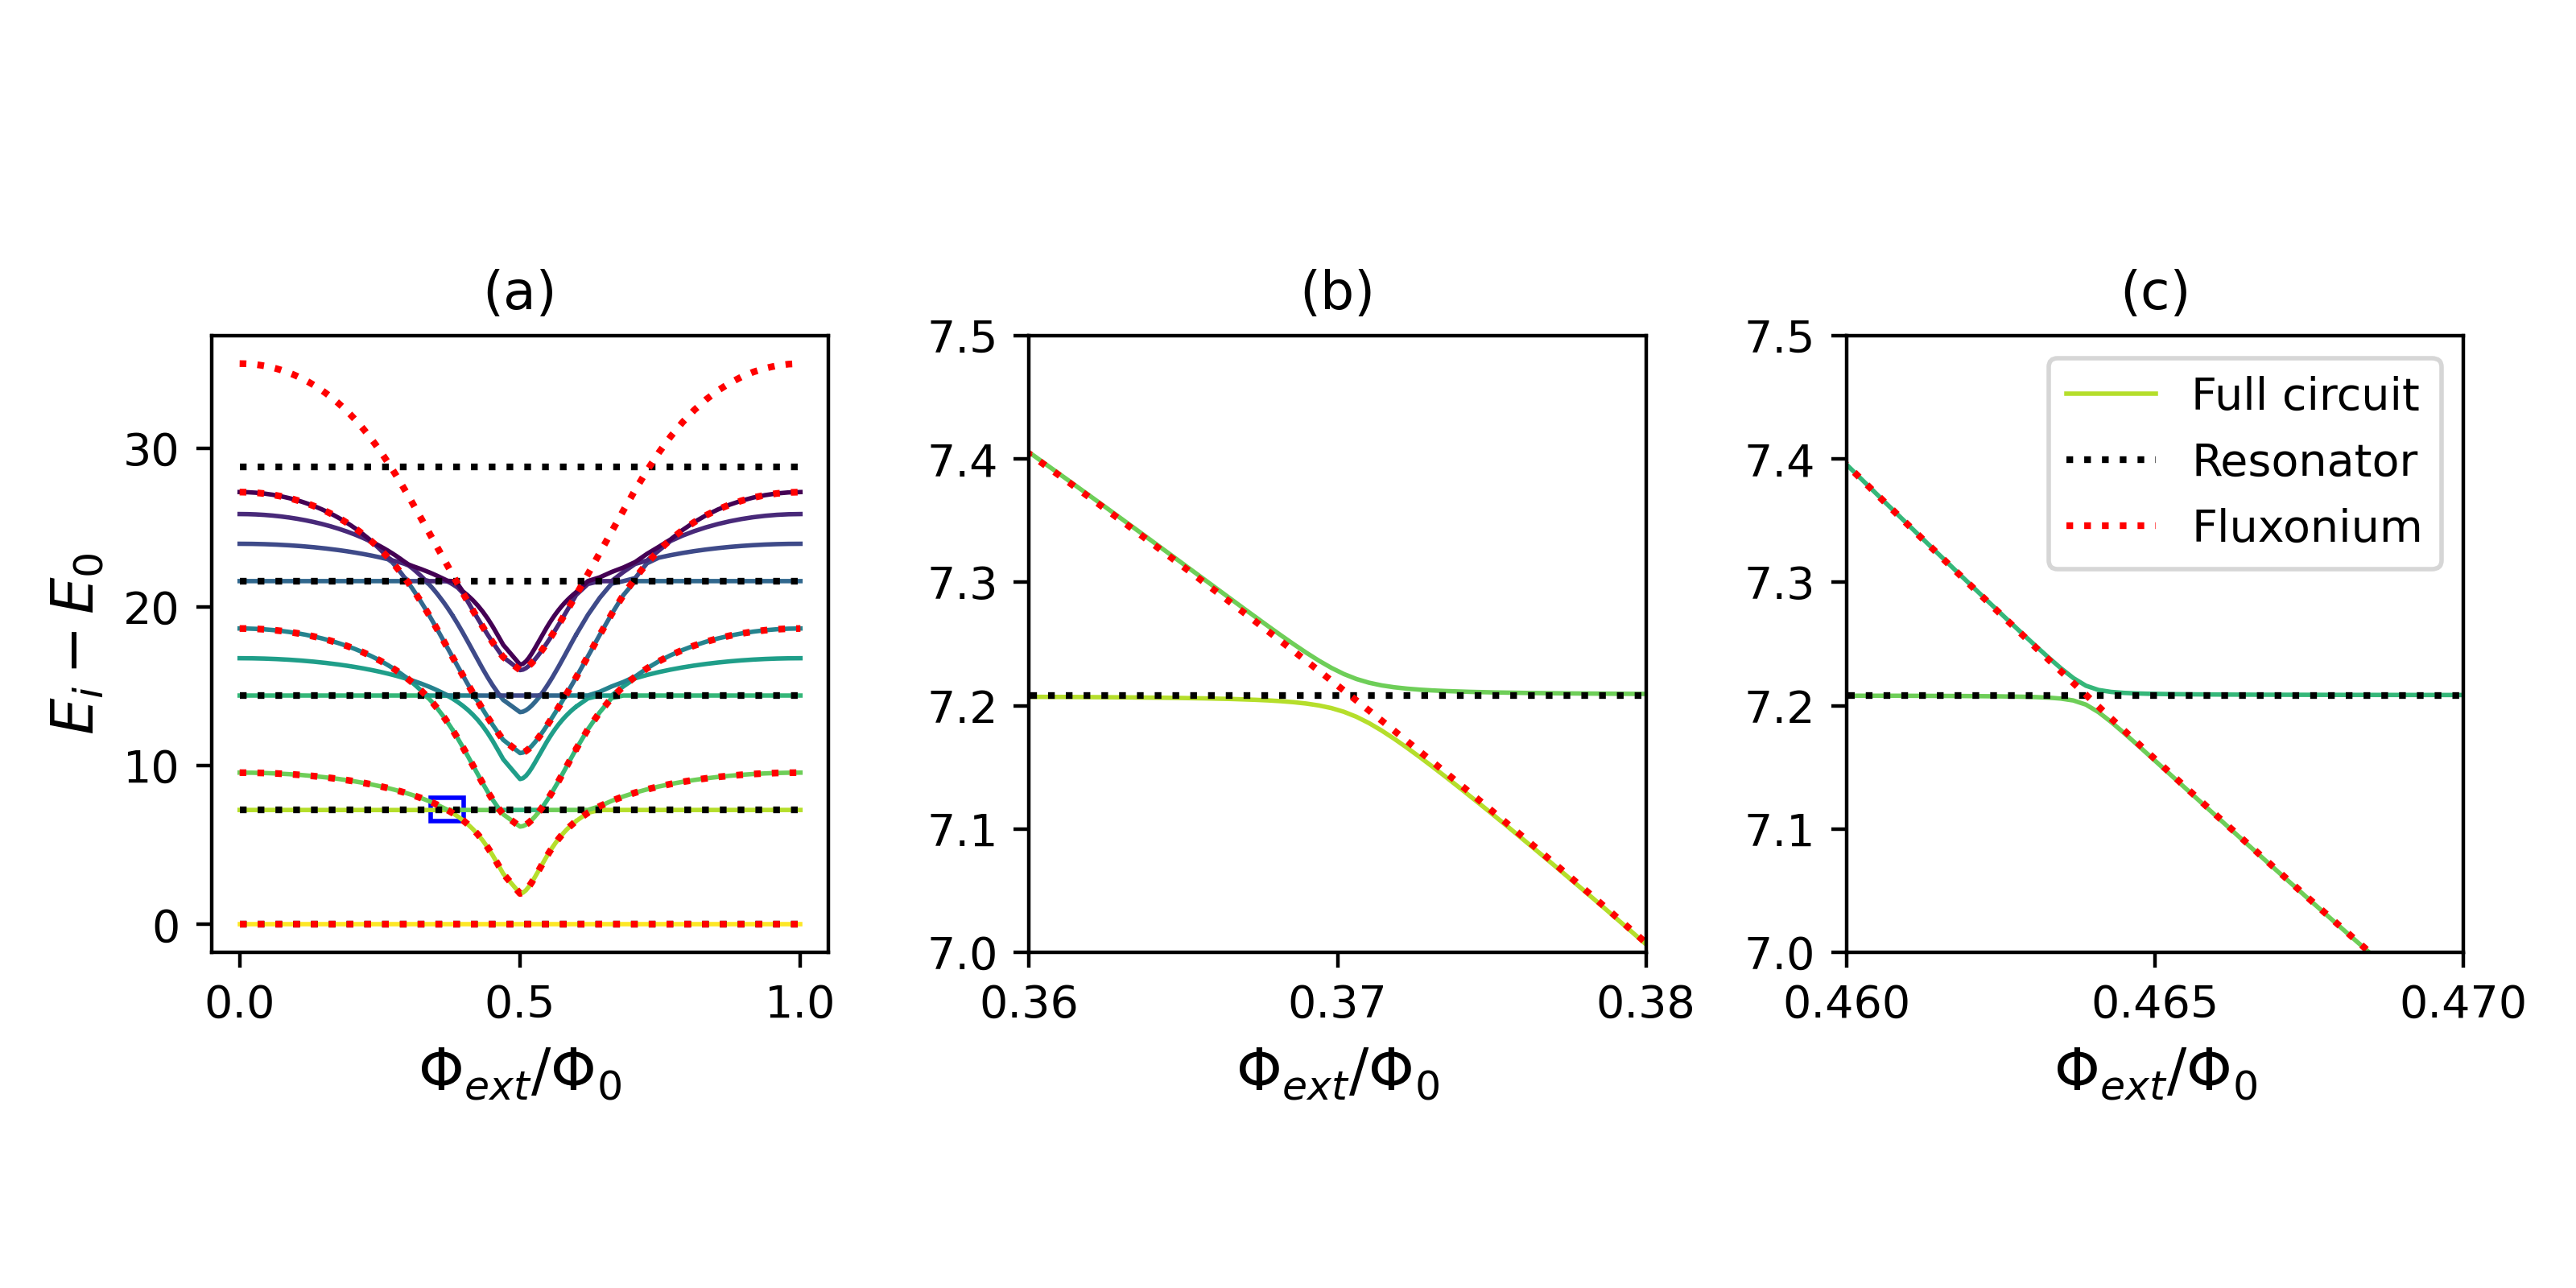

In [22]:
import matplotlib.patches as patches

# Create a rectangle with no fill

fig, axs = plt.subplots(dpi=400, ncols=3, figsize = [8,4])

for ax in axs:
    for i in range(n_eig):
        if i ==1:
            ax.plot(phi, E_circuit[i,:]- E_circuit[0,:], color=eig_colors[i], linewidth=1, label='Full circuit')
        else:
            ax.plot(phi, E_circuit[i,:]- E_circuit[0,:], color=eig_colors[i], linewidth=1)
    for i in range(n_eig//2):
        if i ==0:
            ax.plot([phi[0],phi[-1]], [E_harm[i],E_harm[i]], ':k' , label='Resonator')
            ax.plot(phi, E_fluxonium[i,:]- E_fluxonium[0,:], color='r', linestyle = ':', label='Fluxonium')
        else:
            ax.plot([phi[0],phi[-1]], [E_harm[i],E_harm[i]], ':k' )
            ax.plot(phi, E_fluxonium[i,:]- E_fluxonium[0,:], color='r', linestyle = ':')

    ax.set_box_aspect(1)
    ax.set_xlabel(r"$\Phi_{ext}/\Phi_0$", fontsize=13)
    if ax == axs[0]:
        rect = patches.Rectangle((0.34, 6.5), 0.06, 1.5, linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
        ax.set_title('(a)')
        ax.set_ylabel(r"$E_i-E_0$", fontsize=13)
    elif ax == axs[1]:
        ax.set_title('(b)')
        ax.set_xlim(0.36,0.38)
        ax.set_ylim(7,7.5)

    else :
        ax.set_title('(c)')
        ax.set_xlim(0.46,0.47)
        ax.set_ylim(7,7.5)
        ax.set_xticks([0.46, 0.465, 0.47])
        ax.legend()
fig.tight_layout()
fig.show()
figs.export('Spectrum.pdf')

# Eigenstates

In [16]:
fig_eigs, axs_eigs = plt.subplots(nrows=2, ncols=2)
axs_eigs[0,0].set_title('(a)')
axs_eigs[0,1].set_title('(b)')
axs_eigs[1,0].set_title('(c)')
axs_eigs[1,1].set_title('(d)')

Text(0.5, 1.0, '(d)')

## Potential energy and eigenstates resoantor

In [10]:
E_L_r = (Φ_0/(2*np.pi))**2/L_r / h

φ_r = np.linspace(-3,3,200)
n_eig = 2

V_r = 0.5 * E_L_r * (φ_r)**2

resonator.set_trunc_nums([20])
_, _ = resonator.diag(n_eig)

states_r = [resonator.eig_phase_coord(k=i, grid=[φ_r/2/np.pi]) for i in range(n_eig)]
labels_r = [r'$\psi_R^0$', r'$\psi_R^1$']

fig, ax_r = plt.subplots()
for ax in [ax_r, axs_eigs[0,0]]:
    ax.plot(φ_r, (V_r-V_r.min())/1e9, 'k:')#, label = r'$\frac{1}{2}E_{L_{R}}\varphi_R^2$')
    [ax.plot(φ_r, np.abs(state)**2, label = label) for state, label in zip(states_r, labels_r)]
    ax.set_ylim([-.1,3])
    ax.set_xlabel(r'$\varphi_R$')
    ax.legend()
fig.show()

NameError: name 'axs_eigs' is not defined

## Potential energy and eigenstates of the fluxonium


In [11]:
L_q = l / (Lq + 4*Lr) * 1e-9
E_J = EJ * 1e9

In [12]:
E_L_f = (Φ_0/(2*np.pi))**2/L_q / h
E_C = e0**2 / (2*(C/2 + Csh + CJ)*1e-15) / h

In [13]:
print(E_L_f/GHz, E_C/GHz, E_J/GHz)

6.53862146295341 0.7596168362611421 10.0


In [14]:
E_J / E_L_f

1.5293743576773948

In [15]:
# φ_f = np.linspace(-4, 4, 200)
# φ_ext = np.pi
# # φ_ext = 0
# V_f = 0.5 * E_L_f * (φ_f) ** 2 - E_J * np.cos(φ_f - φ_ext)
# 
# n_eig = 3
# _, _ = fluxonium_qutrit.diag(n_eig, real=True)
# states_f = [fluxonium_qutrit.eig_phase_coord(k=i, grid=[φ_f / 2 / np.pi]) for i in range(n_eig)]
# # states_f = [fluxonium_qutrit.eig_phase_coord(k=i, grid=[φ_f]) for i in range(n_eig)]
# labels_f = [r'$\psi_F^0$', r'$\psi_F^1$', r'$\psi_F^2$']
# colors_f = ['r', 'g', 'b']
# fig, ax_f = plt.subplots()
# 
# ax_f.plot(φ_f, (V_f - V_f.min()) / GHz,
#           'k:')  #, label = r'$\frac{1}{2}E_{L_{F}}\varphi_F^2 - E_J\cos(\varphi_F-\varphi_{ext})$')
# # [ax_f.plot(φ_f, np.abs(state)**2, label = label) for state, label in zip(states_f, labels_f)]
# [ax_f.plot(φ_f, np.real(state), label=label, color=color) for state, label, color in zip(states_f, labels_f, colors_f)]
# [ax_f.plot(φ_f, np.imag(state), '--', label=label, color=color) for state, label, color in
#  zip(states_f, labels_f, colors_f)]
# ax_f.set_ylim([-2, 3])
# # ax_f.set_xlim([-4,4])
# ax_f.set_xlabel(r'$\varphi_F$')
# ax_f.legend(loc=1, framealpha=1)
# 
# fig.show()

In [18]:
φ_f = np.linspace(-3,3,200)
φ_ext = np.pi
φ_ext = 0
V_f = 0.5 * E_L_f * (φ_f)**2 - E_J * np.cos(φ_f-φ_ext)

n_eig = 3
fluxonium.set_trunc_nums([20])
loop_fluxonium.set_flux(φ_ext/2/np.pi)
_, _ = fluxonium.diag(n_eig)
states_f = [fluxonium.eig_phase_coord(k=i, grid=[φ_f/2/np.pi]) for i in range(n_eig)]
# states_f = [fluxonium.eig_phase_coord(k=i, grid=[φ_q]) for i in range(n_eig)]
labels_f = [r'$\psi_F^0$', r'$\psi_F^1$', r'$\psi_F^2$']
colors_f = ['r', 'g', 'b']
fig, ax_f = plt.subplots()
for ax in [ax_f, axs_eigs[0,1]]:
    ax.plot(φ_r, (V_f-V_f.min())/1e9, 'k:')#, label = r'$\frac{1}{2}E_{L_{F}}\varphi_F^2 - E_J\cos(\varphi_F-\varphi_{ext})$')
    # [ax.plot(φ_f, np.abs(state)**2, label = label) for state, label in zip(states_f, labels_f)]
    [ax.plot(φ_f, np.real(state), label = label, color=color) for state, label, color in zip(states_f, labels_f, colors_f)]
    [ax.plot(φ_f, np.imag(state), '--', label = label, color=color) for state, label, color in zip(states_f, labels_f, colors_f)]
    ax.set_ylim([-2,4])
    ax.set_xlabel(r'$\varphi_F$')
    ax.legend(loc=1, framealpha=1)

fig.show()

NameError: name 'axs_eigs' is not defined

## Eigenstates of the qubit in phase base

In [23]:
qubit.set_trunc_nums([5,10])

# creat the phase grid
phi1 = 0
phi2 = np.linspace(-.03, .03, 100)
phi3 = np.linspace(-3, 3 , 100)
grid = [phi1, phi2/2/np.pi, phi3/2/np.pi]

state0_vs_ext_flux = []
state1_vs_ext_flux = []
state2_vs_ext_flux = []
state3_vs_ext_flux = []

ext_flux_list = [0.5, 0.55, 0.65, 1]
# loop thorugh several values of external flux
for ext_flux in ext_flux_list:
    loop.set_flux(ext_flux)
    _, _ = qubit.diag(n_eig=5)

    # Calculate eigenstates in phase coord
    state0_vs_ext_flux.append(qubit.eig_phase_coord(0, grid=grid))
    state1_vs_ext_flux.append(qubit.eig_phase_coord(1, grid=grid))
    state2_vs_ext_flux.append(qubit.eig_phase_coord(2, grid=grid))
    state3_vs_ext_flux.append(qubit.eig_phase_coord(3, grid=grid))

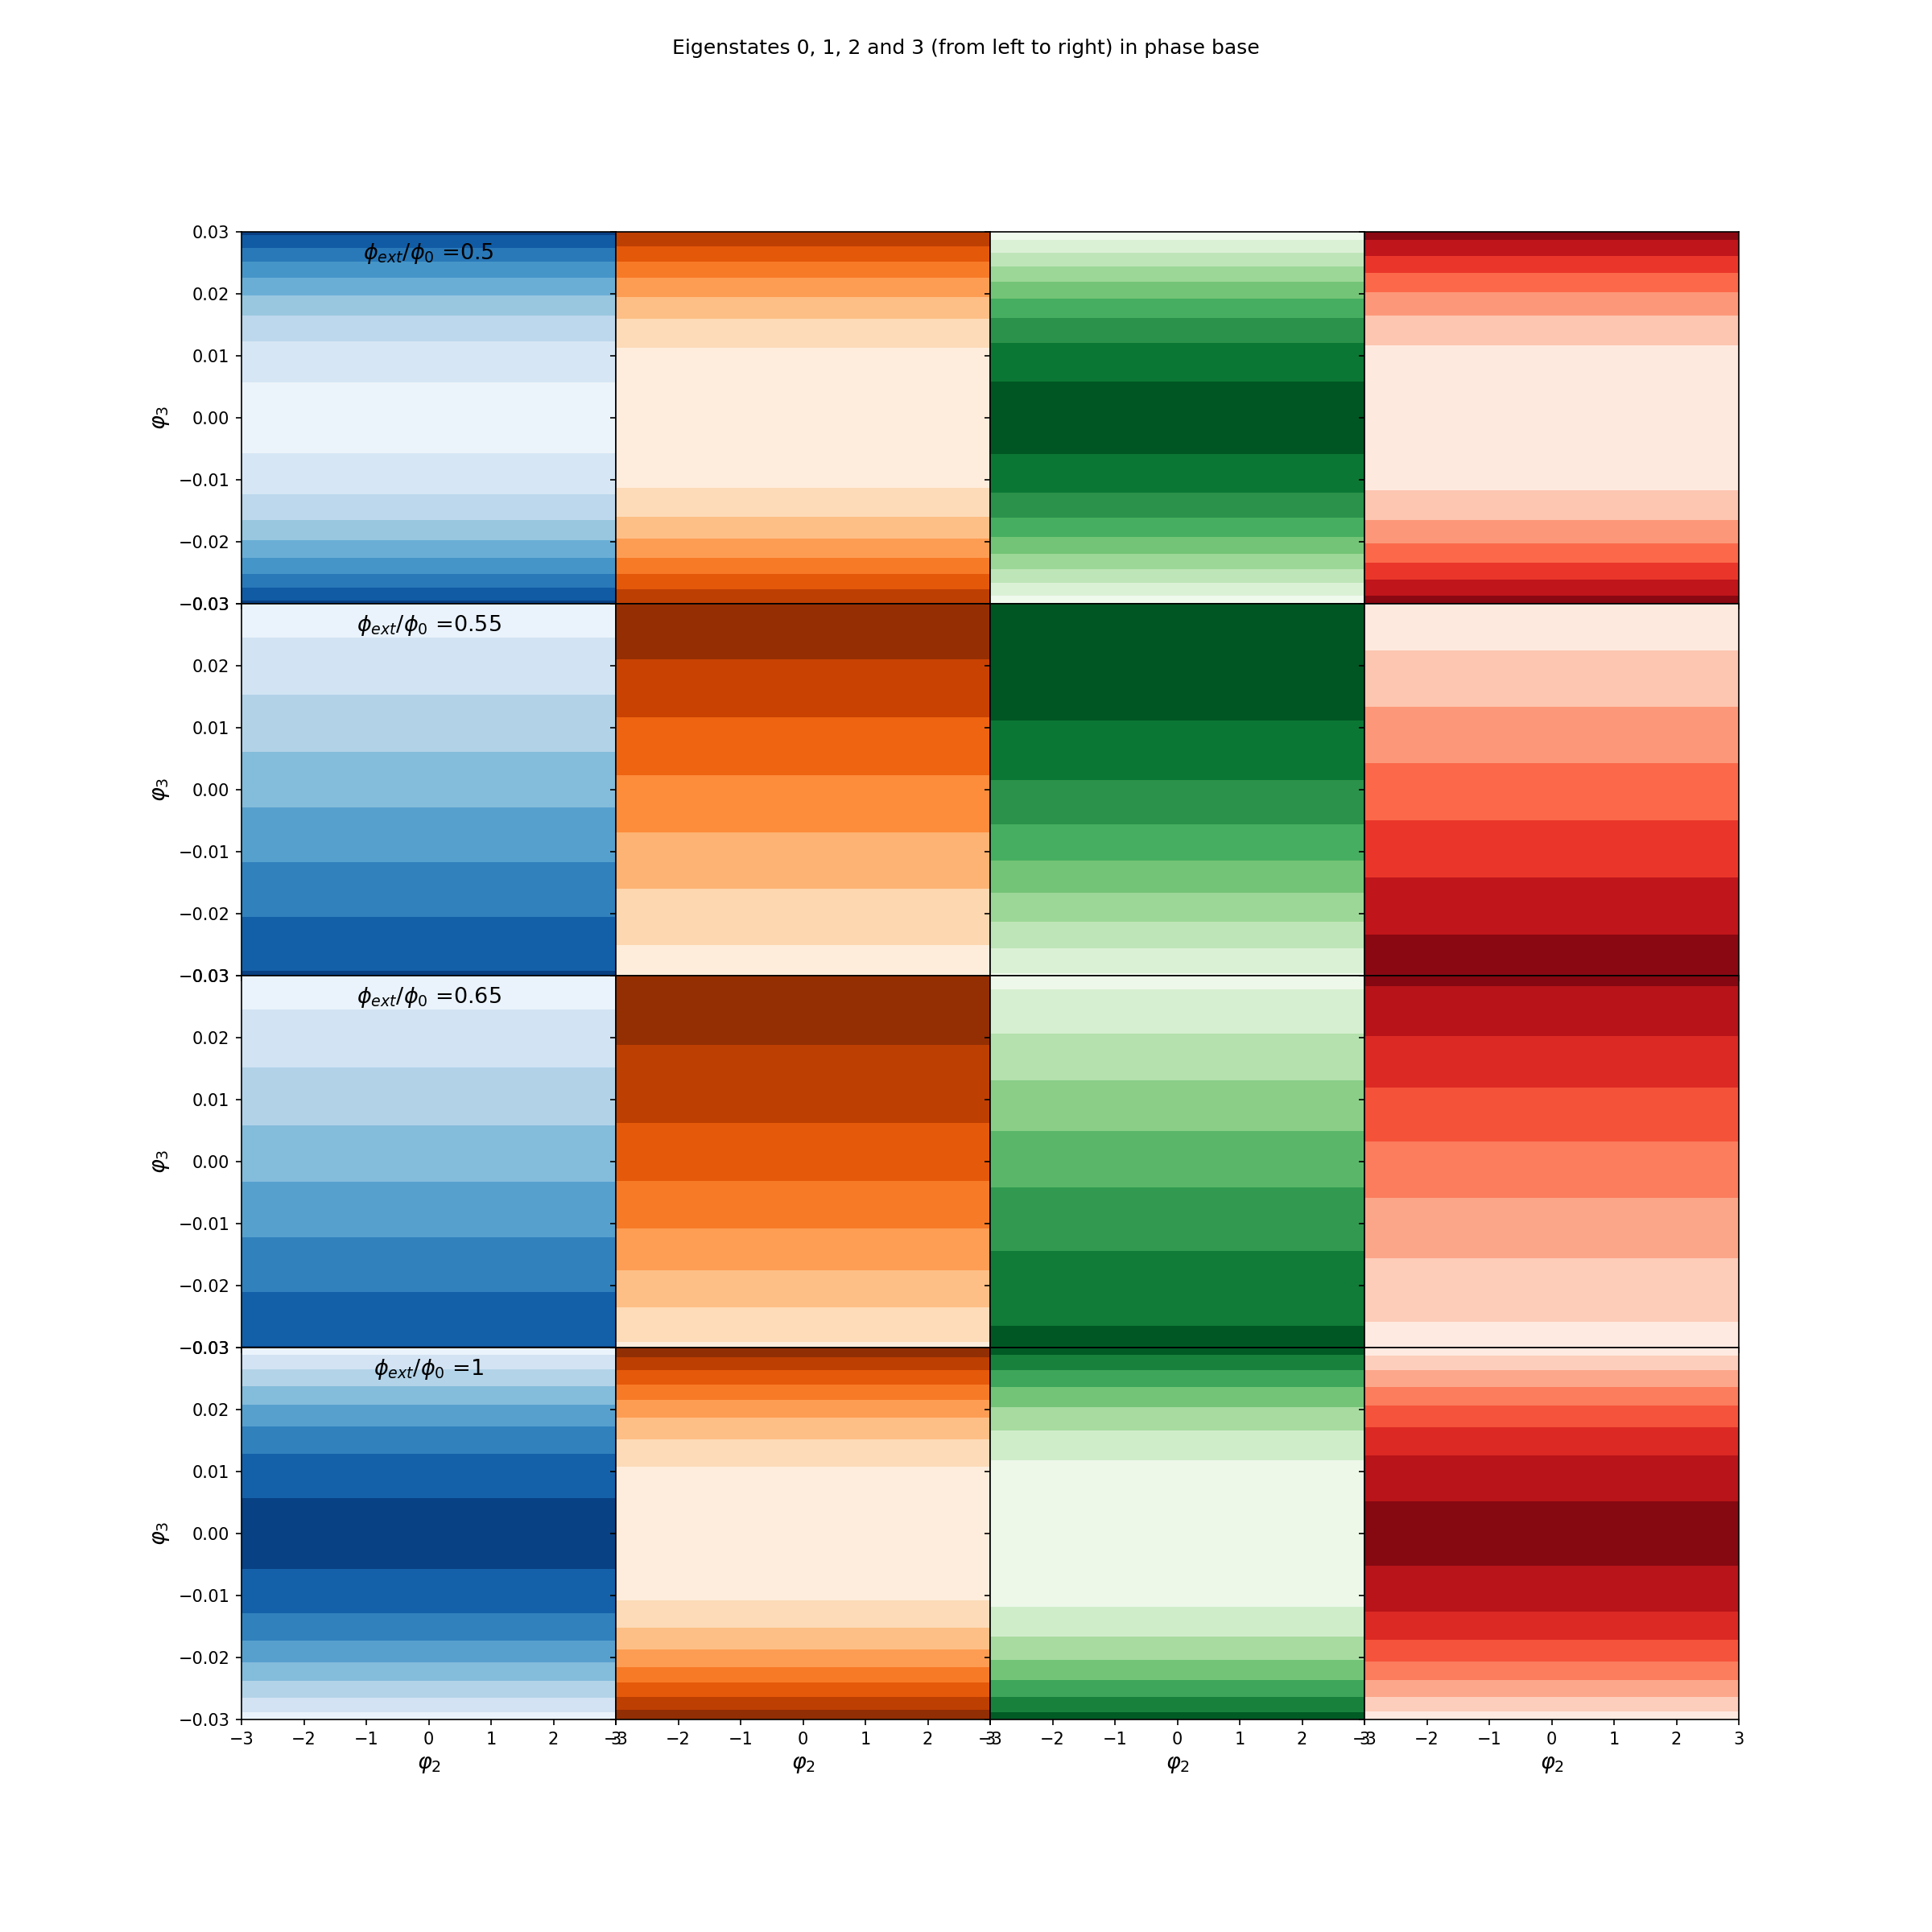

In [24]:
fig, axs = plt.subplots(4, 4, figsize=(4*4, 4*4), sharey='row', sharex = 'col', dpi=150)

for i, ext_flux in enumerate(ext_flux_list):
    axs[i, 0].contourf(phi3, phi2, np.abs(state0_vs_ext_flux[i].T) ** 2, cmap="Blues" )
    axs[i, 1].contourf(phi3, phi2, np.abs(state1_vs_ext_flux[i].T) ** 2, cmap="Oranges" )
    axs[i, 2].contourf(phi3, phi2, np.abs(state2_vs_ext_flux[i].T) ** 2, cmap="Greens")
    axs[i, 3].contourf(phi3, phi2, np.abs(state3_vs_ext_flux[i].T) ** 2, cmap="Reds"   )
    if i == 0:
        axs_eigs[1, 0].contourf(phi3, phi2, np.abs(state0_vs_ext_flux[i].T) ** 2, cmap="Blues")
        axs_eigs[1, 0]. set_ylabel(r'$\tilde{\varphi}_R$')
        axs_eigs[1, 0]. set_xlabel(r'$\tilde{\varphi}_F$')
        axs_eigs[1, 0].text(.9,.9, r'$\psi^0$', transform=axs_eigs[1, 0].transAxes, ha="center", va="center")
        axs_eigs[1, 1].contourf(phi3, phi2, np.abs(state1_vs_ext_flux[i].T) ** 2, cmap="Oranges")
        axs_eigs[1, 1]. set_ylabel(r'$\tilde{\varphi}_R$')
        axs_eigs[1, 1]. set_xlabel(r'$\tilde{\varphi}_F$')
        axs_eigs[1, 1].text(.9,.9, r'$\psi^1$', transform=axs_eigs[1, 1].transAxes, ha="center", va="center")
    for j in range(4):
        axs[-1, j].set_xlabel(r"$\varphi_2$", fontsize=13)
    axs[i, 0].set_ylabel(r"$\varphi_3$", fontsize=13)
    axs[i, 0].set_title('$\phi_{ext}/\phi_{0}$ ='+f'{ext_flux}', fontsize=13, y=0.9 )
fig.suptitle('Eigenstates 0, 1, 2 and 3 (from left to right) in phase base')
plt.subplots_adjust(wspace=0)
plt.subplots_adjust(hspace=0)
plt.show()

# Eigenstates of the separate and combined systems

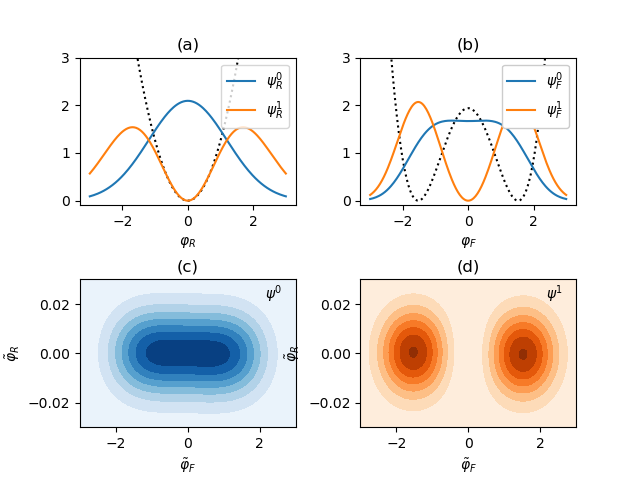

In [22]:
figs.export('Eigenstates.pdf', fig_eigs, hspace=.5, wspace=.3)
fig_eigs.show()

# Fluxonium-Resonator internal coupling in KIT's qubit

### Approach 1: Numerical evaluation of the coupling that has been deduced from the Hamiltonian.

### Approach 1a: Using the fluxonium and resonator circuits.

In [86]:
n_eig=5
n_max=40

fluxonium_0 = sq_ext.sq_fluxonium(Δ=0)
resonator_0 = sq_ext.sq_resonator(Δ=0)
fluxonium = sq_ext.sq_fluxonium()
resonator = sq_ext.sq_resonator()

resonator_0.set_trunc_nums([n_max])
fluxonium_0.set_trunc_nums([n_max])
resonator.set_trunc_nums  ([n_max])
fluxonium.set_trunc_nums  ([n_max])

_ = fluxonium.diag(n_eig)
_ = resonator.diag(n_eig)
_ = fluxonium_0.diag(n_eig)
_ = resonator_0.diag(n_eig)

In [87]:
H_frc = sq_ext.hamiltonian_qubit(fluxonium,resonator,Δ)
H_frc_0 = sq_ext.hamiltonian_qubit(fluxonium_0,resonator_0,Δ=0)

In [90]:
H_eff_p1 = sq_ext.H_eff_p1(H_frc_0,H_frc,n_eig)
print(np.round(H_eff_p1,4))

[[6.707e+00 -0.000e+00 1.000e-04 0.000e+00 2.890e-02]
 [-0.000e+00 8.652e+00 0.000e+00 2.890e-02 0.000e+00]
 [1.000e-04 0.000e+00 1.287e+01 0.000e+00 2.800e-02]
 [0.000e+00 2.890e-02 0.000e+00 1.392e+01 -0.000e+00]
 [2.890e-02 0.000e+00 2.800e-02 -0.000e+00 1.586e+01]]


In [91]:
H_eff_SWT = sq_ext.H_eff_SWT(H_frc_0,H_frc,n_eig)
print(np.round(H_eff_SWT,4))

[[6.707e+00 -0.000e+00 1.000e-04 0.000e+00 2.890e-02]
 [-0.000e+00 8.652e+00 0.000e+00 2.890e-02 -0.000e+00]
 [1.000e-04 0.000e+00 1.287e+01 -0.000e+00 2.800e-02]
 [0.000e+00 2.890e-02 -0.000e+00 1.392e+01 -0.000e+00]
 [2.890e-02 -0.000e+00 2.800e-02 -0.000e+00 1.586e+01]]


In [122]:
# Δ01 = qubit.efreqs[1]- qubit.efreqs[0]
# Δ01

In [123]:
E = sq_ext.diag(H_frc, out='GHz')[0]

In [124]:
Δ01 = E[1]-E[0]

In [103]:
Φ_f = np.real(fluxonium.flux_op(0, basis='eig').__array__())[0,1]
Φ_f

38.41921743281487

In [104]:
Φ_r = np.real(resonator.flux_op(0, basis='eig').__array__())[0,1]
Φ_r

38.365896677177304

In [107]:
g_H_eff_p1  = H_eff_p1 [0, 4]
g_H_eff_SWT = H_eff_SWT[0, 4]
print(g_H_eff_p1)
print(g_H_eff_SWT)

0.028874098601513236
0.028873704840053645


In [125]:
g = Φ_r * Φ_f * 2 * Δ / l / 1e-9 / 2 / np.pi / GHz
print(g)

0.02887362553177522


In [129]:
g / Δ01

0.014842293689249168

### Approach 2: Analytical approximation of the coupling that has been deduced from the Hamiltonian.

In [130]:
dVdφ =  lambda φ: E_L_f*φ + E_J*np.sin(φ+np.pi)
φ_min = sp.optimize.fsolve(dVdφ, 1)[0]
φ_min

1.5279722082410827

In [131]:
Φ_f_an =(Φ_0 / (2*np.pi)) * φ_min / np.sqrt(sq.hbar)
Φ_f_an

48.968088326233854

In [132]:
# This should be the same as that calculated numerically
Φ_r_an = np.sqrt(1/2 * np.sqrt(L_r/C_r))
Φ_r_an

38.36589667717856

In [133]:
# This should be the same as that calculated numerically
Φ_f_r_an = np.sqrt(1/2 * np.sqrt(L_f/C_f))
Φ_f_r_an

22.250116364531465

In [137]:
# g_an = Φ_f_an * Φ_r_an /L_c  /GHz/2/np.pi
g_an = Φ_f_an * Φ_r_an * 2 * Δ / l / 1e-9 / 2 / np.pi / GHz
g_an

0.0368015368301328

In [138]:
g_an / Δ01 * 100

1.8917583358121774

## Analytical approximation of the charge operator of the fluxonium


In [16]:
dVdφ =  lambda φ: E_L_f*φ + E_J*np.sin(φ+np.pi)
φ_min = sp.optimize.fsolve(dVdφ, 1)[0]
φ_min

1.5279722082410827

In [39]:
Φ_f_an =(Φ_0 / (2*np.pi)) * φ_min / np.sqrt(sq.hbar)
Φ_f_an

48.968088326233854

In [40]:
ω_f = fluxonium._efreqs[1]-fluxonium._efreqs[0]
ω_f

60061920142.60657

In [41]:
q_f_an = Φ_f_an * ω_f * C_f
q_f_an

0.07499849396995226

In [34]:
q_f_num = np.abs(fluxonium.charge_op(0, basis='eig')[0,1])
q_f_num

0.027668471458695682

In [35]:
q_f_an / q_f_num

2.7106121161016157